In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
from torchsummary import summary
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
import os
from utils.datasets import DatasetLoader
from models.CAM_based_models import MTEXCNN
from models.CAM_based_models import XCM
from utils.training import train_model

# Load data

In [2]:
# Load dataset

dataset_path = './data/UWaveGestureLibrary'
dataset = DatasetLoader(dataset_path)
train_data, test_data = dataset.load_to_df()

In [3]:
X_train, y_train, X_test, y_test = dataset.load_to_nparray()

In [4]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 3, 315)

(120,)

(320, 3, 315)

(320,)

## Create DataLoader

In [5]:
dataloaders, datasets_size = dataset.get_torch_dataset_loader_auto(4, 4)

# CAM-based models

## MTEX-CNN

In [6]:
net = MTEXCNN(X_train.shape[2], len(np.unique(y_train)))
net

MTEXCNN(
  (conv_1): Conv2d(1, 16, kernel_size=(158, 1), stride=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(79, 1), stride=(1, 1))
  (conv_3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv_4): Conv1d(3, 64, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=4992, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
)

In [7]:
summary(net, (1,315,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 158, 3]           2,544
            Conv2d-2            [-1, 32, 80, 3]          40,480
            Conv2d-3             [-1, 1, 80, 3]              33
            Conv1d-4               [-1, 64, 78]             640
            Linear-5                   [-1, 32]         159,776
            Linear-6                    [-1, 8]             264
Total params: 203,737
Trainable params: 203,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.78
Estimated Total Size (MB): 0.94
----------------------------------------------------------------


## XCM

In [8]:
window_size = int(0.3*X_train.shape[2])
if window_size % 2 == 0:
    window_size -= 1

net1 = XCM(window_size, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net1

XCM(
  (conv_11): Conv2d(1, 16, kernel_size=(93, 93), stride=(1, 1), padding=(46, 46))
  (batchnorm_11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_12): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv_21): Conv1d(3, 16, kernel_size=(93,), stride=(1,), padding=(46,))
  (batchnorm_21): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_22): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  (conv_3): Conv1d(315, 32, kernel_size=(93,), stride=(1,), padding=(46,))
  (batchnorm_3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (glb_avg_pool): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)

In [9]:
summary(net1, (1,315,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 315, 3]         138,400
       BatchNorm2d-2           [-1, 16, 315, 3]              32
            Conv2d-3            [-1, 1, 315, 3]              17
            Conv1d-4              [-1, 16, 315]           4,480
       BatchNorm1d-5              [-1, 16, 315]              32
            Conv1d-6               [-1, 1, 315]              17
            Conv1d-7                [-1, 32, 4]         937,472
       BatchNorm1d-8                [-1, 32, 4]              64
         AvgPool1d-9                [-1, 32, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                    [-1, 8]             264
          Softmax-12                    [-1, 8]               0
Total params: 1,080,778
Trainable params: 1,080,778
Non-trainable params: 0
---------------------------

# Training

In [10]:
# from torch_lr_finder import LRFinder

# model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
# criterion = nn.CrossEntropyLoss()
# optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-6)

# lr_finder = LRFinder(model.double(), optimizer_ft, criterion)
# lr_finder.range_test(dataloaders['train'], val_loader=dataloaders['val'], end_lr=1e-3, num_iter=100, step_mode="exp")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

Epoch 0/49
----------
train Loss: 2.0194 Acc: 0.4417 Correct: 53.0
val Loss: 2.0097 Acc: 0.6438 Correct: 206.0


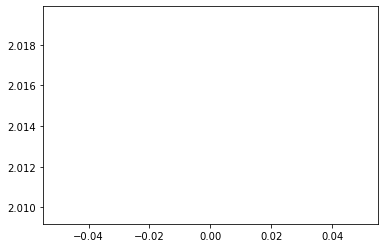

Epoch 1/49
----------
train Loss: 1.9700 Acc: 0.6000 Correct: 72.0
val Loss: 1.8622 Acc: 0.7031 Correct: 225.0


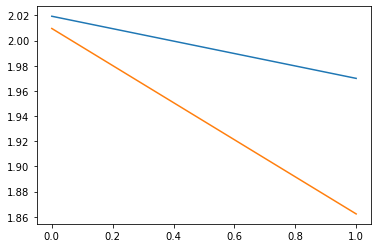

Epoch 2/49
----------
train Loss: 1.9442 Acc: 0.6667 Correct: 80.0
val Loss: 1.8223 Acc: 0.7750 Correct: 248.0


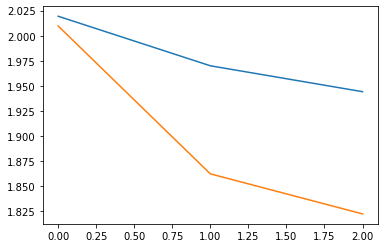

Epoch 3/49
----------
train Loss: 1.9271 Acc: 0.6917 Correct: 83.0
val Loss: 1.8430 Acc: 0.7812 Correct: 250.0


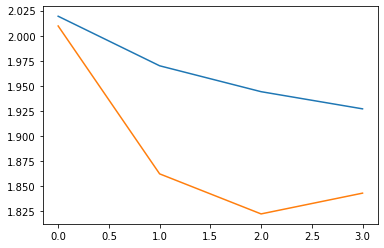

Epoch 4/49
----------
train Loss: 1.9048 Acc: 0.7750 Correct: 93.0
val Loss: 1.8210 Acc: 0.7750 Correct: 248.0


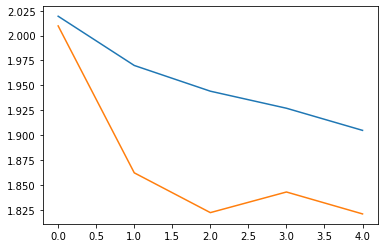

Epoch 5/49
----------
train Loss: 1.8941 Acc: 0.7583 Correct: 91.0
val Loss: 1.8025 Acc: 0.7812 Correct: 250.0


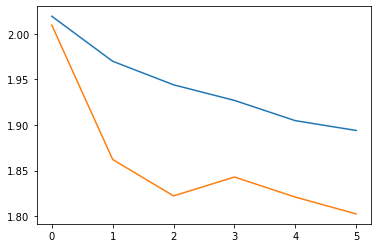

Epoch 6/49
----------
train Loss: 1.8586 Acc: 0.8083 Correct: 97.0
val Loss: 1.8132 Acc: 0.7719 Correct: 247.0


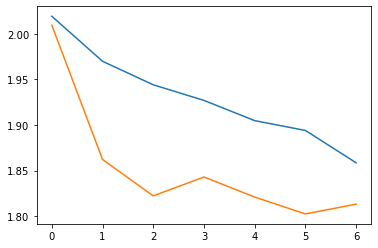

Epoch 7/49
----------
train Loss: 1.8672 Acc: 0.7667 Correct: 92.0
val Loss: 1.7785 Acc: 0.7937 Correct: 254.0


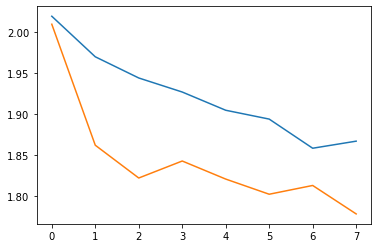

Epoch 8/49
----------
train Loss: 1.8510 Acc: 0.7500 Correct: 90.0
val Loss: 1.7869 Acc: 0.7781 Correct: 249.0


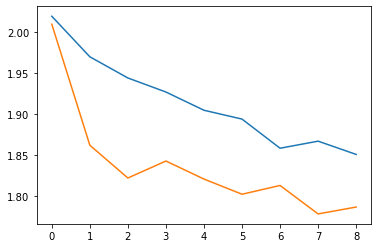

Epoch 9/49
----------
train Loss: 1.8403 Acc: 0.8000 Correct: 96.0
val Loss: 1.7473 Acc: 0.8063 Correct: 258.0


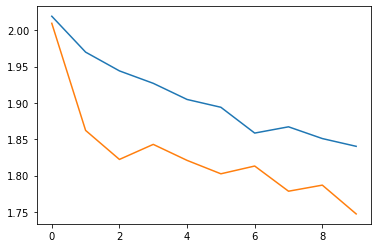

Epoch 10/49
----------
train Loss: 1.8251 Acc: 0.8250 Correct: 99.0
val Loss: 1.7597 Acc: 0.8031 Correct: 257.0


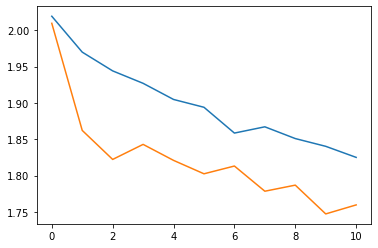

Epoch 11/49
----------
train Loss: 1.8168 Acc: 0.8500 Correct: 102.0
val Loss: 1.7645 Acc: 0.7875 Correct: 252.0


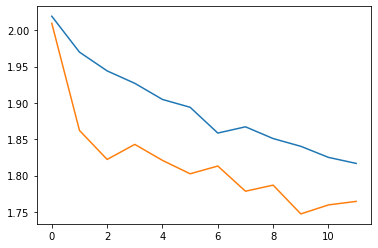

Epoch 12/49
----------
train Loss: 1.8377 Acc: 0.8000 Correct: 96.0
val Loss: 1.7537 Acc: 0.7875 Correct: 252.0


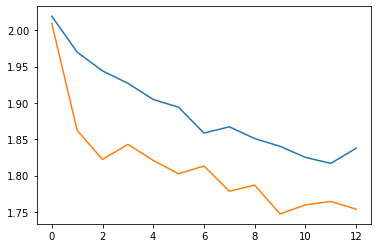

Epoch 13/49
----------
train Loss: 1.8316 Acc: 0.8167 Correct: 98.0
val Loss: 1.7588 Acc: 0.8031 Correct: 257.0


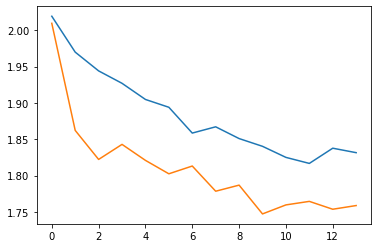

Epoch 14/49
----------
train Loss: 1.8280 Acc: 0.7917 Correct: 95.0
val Loss: 1.7576 Acc: 0.7937 Correct: 254.0


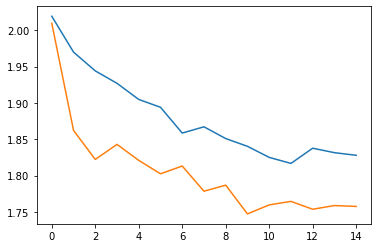

Epoch 15/49
----------
train Loss: 1.8144 Acc: 0.8417 Correct: 101.0
val Loss: 1.7508 Acc: 0.8063 Correct: 258.0


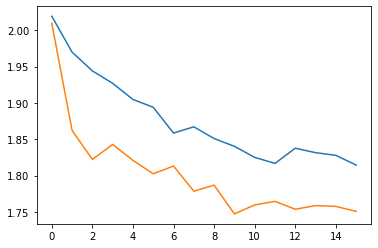

Epoch 16/49
----------
train Loss: 1.8366 Acc: 0.7667 Correct: 92.0
val Loss: 1.7355 Acc: 0.8031 Correct: 257.0


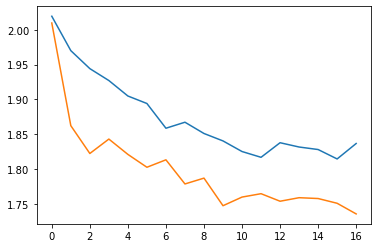

Epoch 17/49
----------
train Loss: 1.8121 Acc: 0.8667 Correct: 104.0
val Loss: 1.7567 Acc: 0.8125 Correct: 260.0


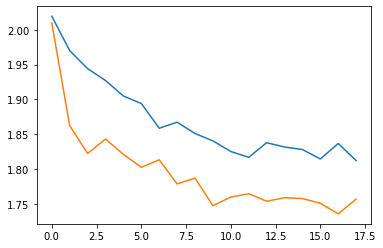

Epoch 18/49
----------
train Loss: 1.8073 Acc: 0.7750 Correct: 93.0
val Loss: 1.7558 Acc: 0.8031 Correct: 257.0


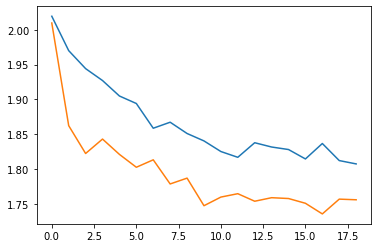

Epoch 19/49
----------
train Loss: 1.8226 Acc: 0.8083 Correct: 97.0
val Loss: 1.7413 Acc: 0.7969 Correct: 255.0


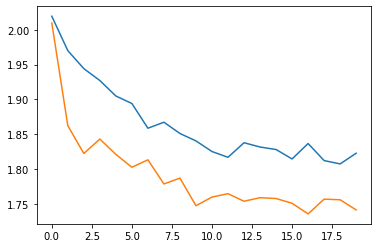

Epoch 20/49
----------
train Loss: 1.8323 Acc: 0.7833 Correct: 94.0
val Loss: 1.7351 Acc: 0.8000 Correct: 256.0


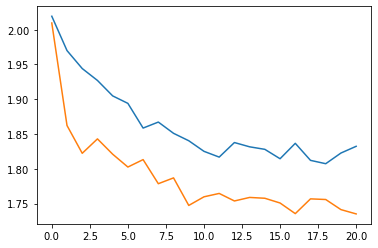

Epoch 21/49
----------
train Loss: 1.8082 Acc: 0.8417 Correct: 101.0
val Loss: 1.7451 Acc: 0.7937 Correct: 254.0


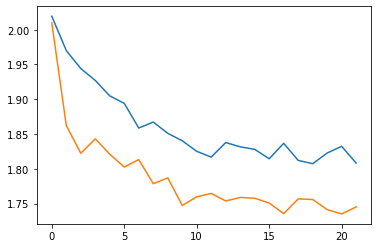

Epoch 22/49
----------
train Loss: 1.8195 Acc: 0.8083 Correct: 97.0
val Loss: 1.7394 Acc: 0.8156 Correct: 261.0


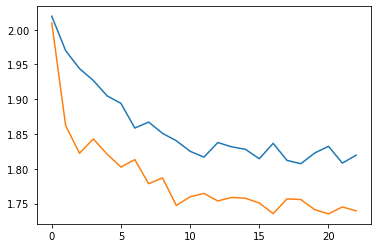

Epoch 23/49
----------
train Loss: 1.8300 Acc: 0.7833 Correct: 94.0
val Loss: 1.7420 Acc: 0.8063 Correct: 258.0


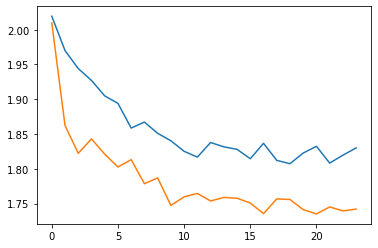

Epoch 24/49
----------
train Loss: 1.8022 Acc: 0.8417 Correct: 101.0
val Loss: 1.7314 Acc: 0.7812 Correct: 250.0


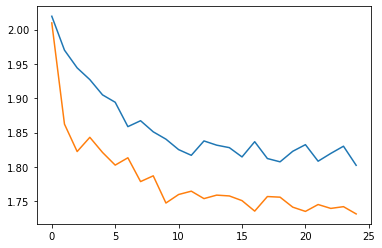

Epoch 25/49
----------
train Loss: 1.8161 Acc: 0.8167 Correct: 98.0
val Loss: 1.7485 Acc: 0.8031 Correct: 257.0


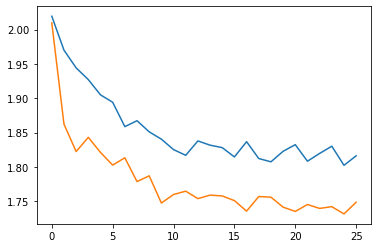

Epoch 26/49
----------
train Loss: 1.8108 Acc: 0.8667 Correct: 104.0
val Loss: 1.7442 Acc: 0.7937 Correct: 254.0


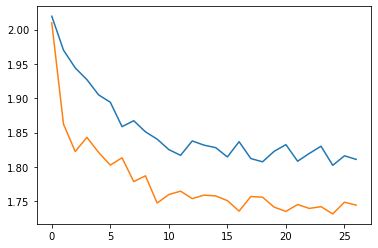

Epoch 27/49
----------
train Loss: 1.8148 Acc: 0.7917 Correct: 95.0
val Loss: 1.7384 Acc: 0.7906 Correct: 253.0


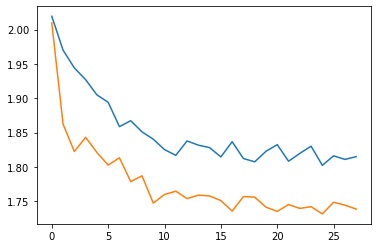

Epoch 28/49
----------
train Loss: 1.8172 Acc: 0.8000 Correct: 96.0
val Loss: 1.7400 Acc: 0.7875 Correct: 252.0


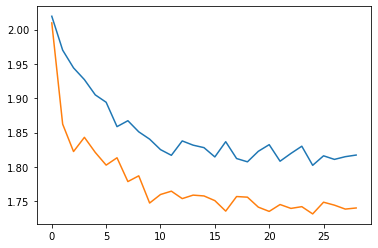

Epoch 29/49
----------
train Loss: 1.8195 Acc: 0.8167 Correct: 98.0
val Loss: 1.7370 Acc: 0.7906 Correct: 253.0


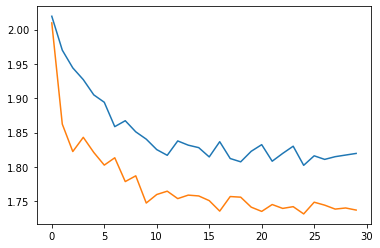

Epoch 30/49
----------
train Loss: 1.8140 Acc: 0.8167 Correct: 98.0
val Loss: 1.7322 Acc: 0.7875 Correct: 252.0


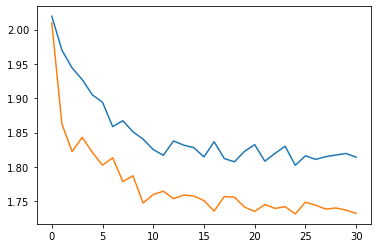

Epoch 31/49
----------
train Loss: 1.8214 Acc: 0.8083 Correct: 97.0
val Loss: 1.7190 Acc: 0.8187 Correct: 262.0


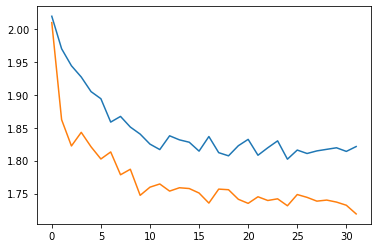

Epoch 32/49
----------
train Loss: 1.8212 Acc: 0.8000 Correct: 96.0
val Loss: 1.7364 Acc: 0.8063 Correct: 258.0


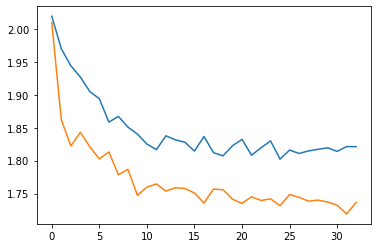

Epoch 33/49
----------
train Loss: 1.8201 Acc: 0.8250 Correct: 99.0
val Loss: 1.7286 Acc: 0.8094 Correct: 259.0


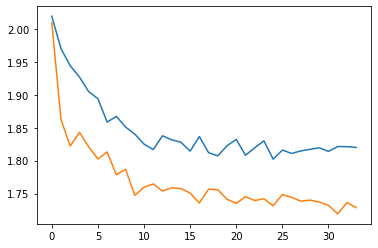

Epoch 34/49
----------
train Loss: 1.8179 Acc: 0.7917 Correct: 95.0
val Loss: 1.7327 Acc: 0.7937 Correct: 254.0


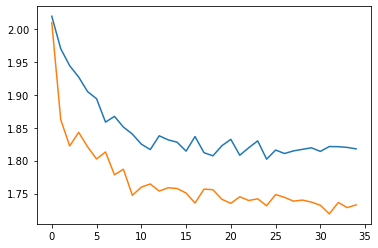

Epoch 35/49
----------
train Loss: 1.8111 Acc: 0.8250 Correct: 99.0
val Loss: 1.7381 Acc: 0.8094 Correct: 259.0


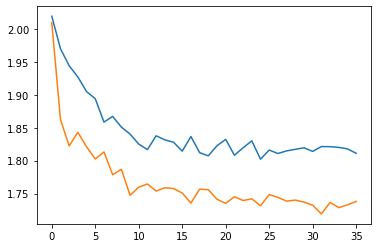

Epoch 36/49
----------
train Loss: 1.7971 Acc: 0.8500 Correct: 102.0
val Loss: 1.7549 Acc: 0.8031 Correct: 257.0


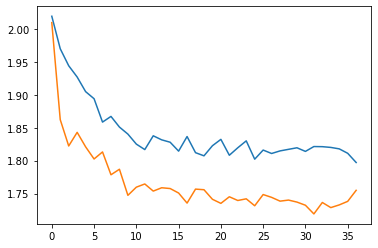

Epoch 37/49
----------
train Loss: 1.8226 Acc: 0.8083 Correct: 97.0
val Loss: 1.7355 Acc: 0.7844 Correct: 251.0


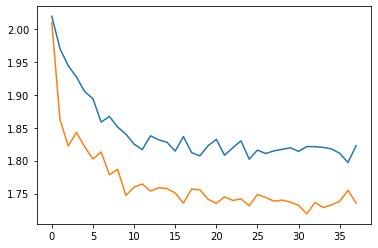

Epoch 38/49
----------
train Loss: 1.8070 Acc: 0.8000 Correct: 96.0
val Loss: 1.7437 Acc: 0.8063 Correct: 258.0


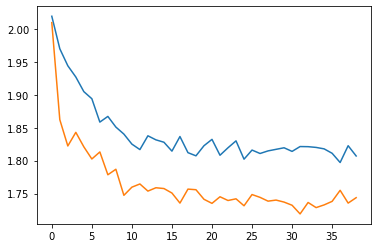

Epoch 39/49
----------
train Loss: 1.8171 Acc: 0.7750 Correct: 93.0
val Loss: 1.7256 Acc: 0.7937 Correct: 254.0


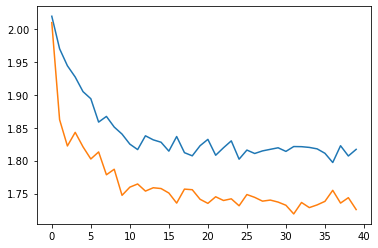

Epoch 40/49
----------
train Loss: 1.8180 Acc: 0.8250 Correct: 99.0
val Loss: 1.7484 Acc: 0.8000 Correct: 256.0


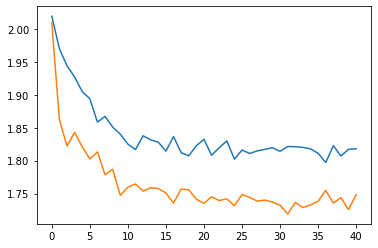

Epoch 41/49
----------
train Loss: 1.8136 Acc: 0.7833 Correct: 94.0
val Loss: 1.7442 Acc: 0.7937 Correct: 254.0


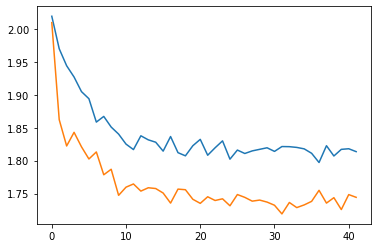

Epoch 42/49
----------
train Loss: 1.8262 Acc: 0.8167 Correct: 98.0
val Loss: 1.7294 Acc: 0.7969 Correct: 255.0


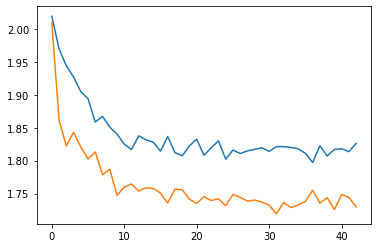

Epoch 43/49
----------
train Loss: 1.7929 Acc: 0.8250 Correct: 99.0
val Loss: 1.7337 Acc: 0.8031 Correct: 257.0


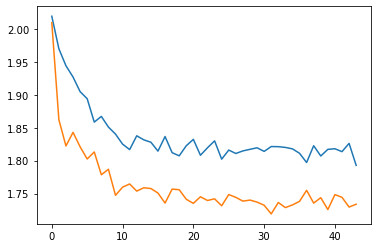

Epoch 44/49
----------
train Loss: 1.8144 Acc: 0.8333 Correct: 100.0
val Loss: 1.7497 Acc: 0.8031 Correct: 257.0


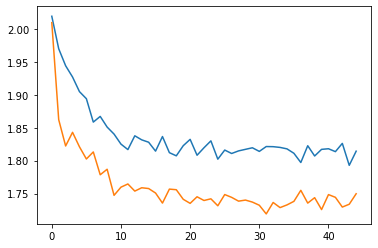

Epoch 45/49
----------
train Loss: 1.8272 Acc: 0.7833 Correct: 94.0
val Loss: 1.7443 Acc: 0.8094 Correct: 259.0


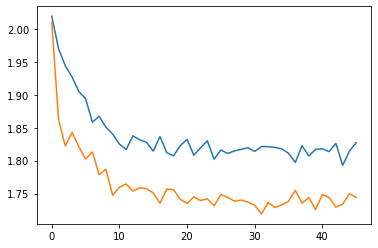

Epoch 46/49
----------
train Loss: 1.8148 Acc: 0.8167 Correct: 98.0
val Loss: 1.7355 Acc: 0.7937 Correct: 254.0


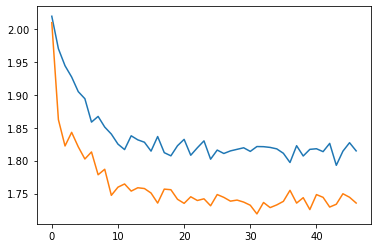

Epoch 47/49
----------
train Loss: 1.8084 Acc: 0.8083 Correct: 97.0
val Loss: 1.7414 Acc: 0.7969 Correct: 255.0


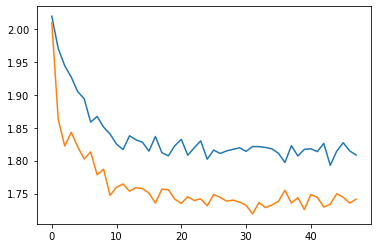

Epoch 48/49
----------
train Loss: 1.8177 Acc: 0.8167 Correct: 98.0
val Loss: 1.7429 Acc: 0.8031 Correct: 257.0


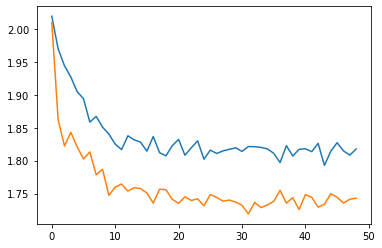

Epoch 49/49
----------
train Loss: 1.8051 Acc: 0.8333 Correct: 100.0
val Loss: 1.7412 Acc: 0.8000 Correct: 256.0


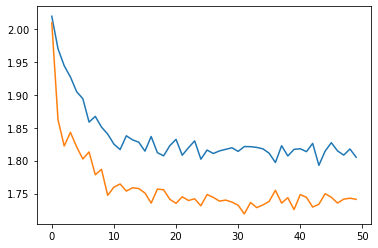

Training complete in 52m 52s
Best val Acc: 0.818750


XCM(
  (conv_11): Conv2d(1, 16, kernel_size=(93, 93), stride=(1, 1), padding=(46, 46))
  (batchnorm_11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_12): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv_21): Conv1d(3, 16, kernel_size=(93,), stride=(1,), padding=(46,))
  (batchnorm_21): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_22): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  (conv_3): Conv1d(315, 32, kernel_size=(93,), stride=(1,), padding=(46,))
  (batchnorm_3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (glb_avg_pool): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)

In [11]:
model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1.5e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, datasets_size, 50)